# Structure analysis

This notebook presents the tools to analyse the structure of solid solutions.


In [365]:
import sys
sys.path.insert(1, '../../crystal-code-tools/crystal_functions/crystal_functions/')

from crystal_functions.file_readwrite import Crystal_output, write_cry_properties, Crystal_input, write_cry_gui,write_cry_input, Crystal_bands
from crystal_functions.execute import runcry
from crystal_functions.convert import cry_gui2pmg,cry_bands2pmg

from pymatgen.io.ase import AseAtomsAdaptor
from pymatgen.io.cif import CifWriter
from ase.visualize import view

from pymatgen.symmetry.analyzer import SpacegroupAnalyzer
from pymatgen.core.surface import SlabGenerator
from pymatgen.electronic_structure.plotter import BSPlotter

import numpy as np
import pandas as pd

## Generate the structures

In this instance, the structures were created by using the data/Configuration.txt file that contains a list of Li atom indices.

In [367]:
with open('data/Configuration.txt') as file:
    data = file.readlines()
manual_li = []
for line in data:
    if line.lstrip(' ').split(' ')[0] != '\n':
        manual_li.append([int(x) for x in line.rstrip('\n').lstrip(' ').rstrip(' ').split(' ')])


In [441]:
original_structure = cry_gui2pmg('data/LTS_CONFCNT_ONLY.gui')
new_atom = 'Li'
structures = []
ti_atoms = []
li_atoms = []
all_ti = [x for x in range(1,28)]
for j,substitutions in enumerate(manual_li):
    new_structure = original_structure.copy()
    for i in substitutions:
        new_structure.replace(i-1,new_atom)
    structures.append(new_structure)
    ti_atoms.append((np.array([i for i in all_ti if i not in manual_li[j]])-1).tolist())
li_atoms = (np.array(manual_li)-1).tolist()

## Visualise the structures


In [520]:
view(AseAtomsAdaptor().get_atoms(structures[1]))

<Popen: returncode: None args: ['/Users/brunocamino/miniconda3/envs/test_env...>

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


## Space group analysis (ADD DF)

In [50]:
space_group = []
for structure in structures:
    space_group.append(SpacegroupAnalyzer(structure).get_space_group_number())
#space_group

## Shells

In [51]:
shells = np.unique(np.round(structures[0].distance_matrix[0],decimals=6)).tolist()
shells

[0.0, 2.54275, 3.595992, 4.404172, 5.0855, 5.685762, 6.22844, 7.62825]

## Average Ti-Ti distance

In [375]:
average_ti = []
std_average_ti = []
average_std_ti_combined = []
for n,structure in enumerate(structures):
    average = 0.
    std_average = []
    for i in ti_atoms[n]:
        for j in ti_atoms[n]: 
            if i != j:
                average += round(structure.sites[i].distance(structure.sites[j]),6)
                std_average.append(structure.sites[i].distance(structure.sites[j]))
    average_ti.append(average/(len(ti_atoms[n])**2))
    std_average_ti.append(np.std(std_average))
    average_std_ti_combined.append([average/(len(ti_atoms[n])**2),np.std(std_average)])

In [376]:
unique_ti_average = np.unique(np.sort(np.array(average_ti)),axis=0)
average_ti_group = []
for i in range(len(structures)):
    average_ti_group.append(np.where(unique_ti_average == average_ti[i])[0][0])

In [403]:
dist_std_unique, dist_std_first, dist_std_occ =  np.unique(np.round(np.array(average_std_ti_combined),6),axis=0,return_counts=True,return_index=True)

## Group structures

In [440]:
average_std_group = []
for unique in dist_std_unique:
    average_std_group.append(np.where(np.all(np.round(np.array(average_std_ti_combined),6) == unique,axis=1))[0].tolist())

## Select the structures
NB: the numbers used here refer to the numbering 1-4023.

In [ ]:
selected_structures = [2, 119, 127, 218, 348, 650, 721, 737, 840, 848, 868, 880, 1097, 1126,
                        1363, 1435, 1526, 1639, 1688, 1887, 2312, 2801, 3579, 3842]

## Plot the average Ti-Ti distance vs the Ti-Ti distance std

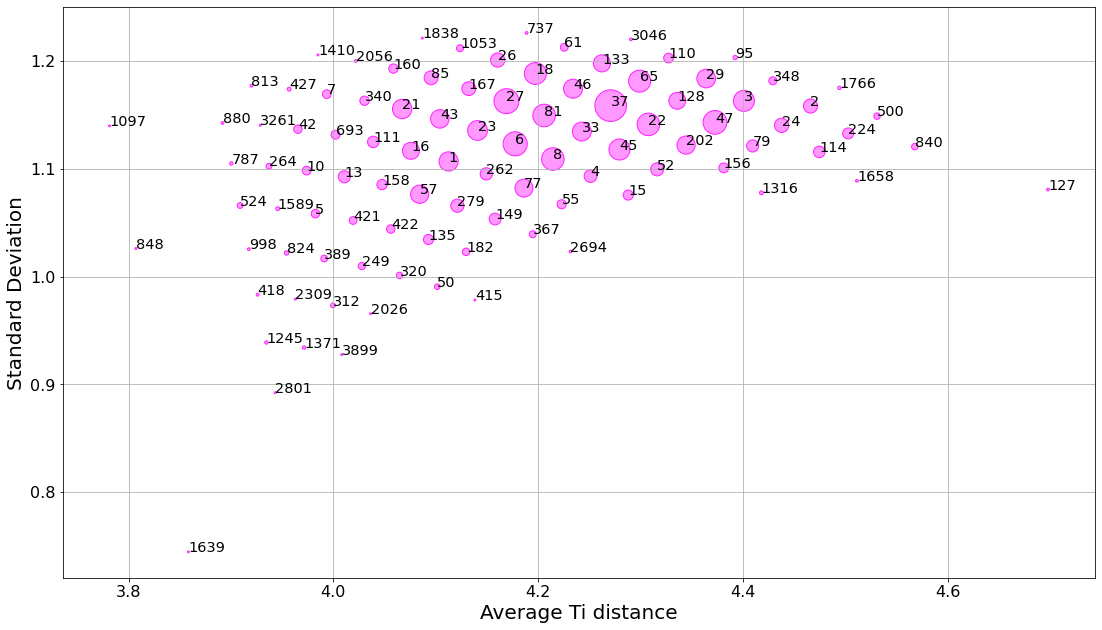

In [417]:
import matplotlib.pyplot as plt

font = {'size'   : 14.5,
       'weight': 'normal'}

plt.rc('font', **font)

color = ['b','g','r','c','m','y','k','tab:orange']
fig, ax = plt.subplots()
ax.scatter(dist_std_unique[:,0], dist_std_unique[:,1],s=dist_std_occ/max(dist_std_occ)*1000, 
           edgecolors='#ff22ff', color='#ff99ff')

label = dist_std_first+1

ax.set_xlabel('Average Ti distance', fontsize=20)
ax.set_ylabel('Standard Deviation', fontsize=20) 
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
ax.grid()

for i, txt in enumerate(label):
    ax.annotate(txt, (dist_std_unique[i,0], dist_std_unique[i,1]),)
fig.set_size_inches(18.5, 10.5)

plt.show()

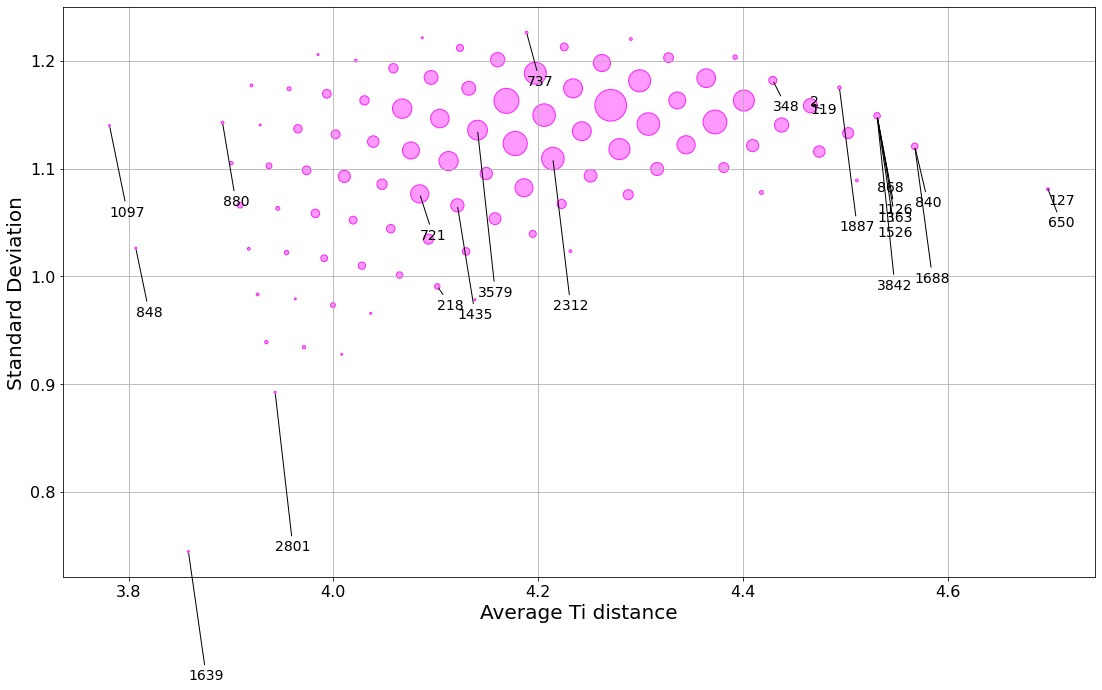

In [549]:
import matplotlib.pyplot as plt


font = {'size'   : 14,
       'weight': 'normal'}

plt.rc('font', **font)

color = ['b','g','r','c','m','y','k','tab:orange']
fig, ax = plt.subplots()
ax.scatter(dist_std_unique[:,0], dist_std_unique[:,1],s=dist_std_occ/max(dist_std_occ)*1000, 
           edgecolors='#ff22ff', color='#ff99ff')

label = selected_structures

ax.set_xlabel('Average Ti distance', fontsize=20)
ax.set_ylabel('Standard Deviation', fontsize=20) 
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
ax.grid()

for i, txt in enumerate(label):
    x = average_std_ti_combined[int(txt)-1][0]
    y = average_std_ti_combined[int(txt)-1][1]
    
    mult = count_selected[np.where(unique_selected == round(x,6))[0][0]]
    b
    xytext = (x,y+-0.007*i)
    ax.annotate(txt,xy=(x,y),xytext=xytext,xycoords='data',arrowprops={'arrowstyle':'-'})

fig.set_size_inches(18.5, 10.5)
#fig.savefig("test.png")
plt.show()

In [496]:
description = ['Ti rows','Dispersed', 'Ti spiral','Ti rows',
               'Dispersed','Dispersed','Ti rows','Ti rows',
               'Dispersed','Ti rows','Dispersed','Vicinal Ti rows',
               'Ti Planes (1 0 0)','Dispersed','Dispersed','Ti rows','Dispersed',
               'Ti Planes (1 1 1)','Dispersed','Dispersed','Ti rows','Ti rows','Dispersed','Dispersed']

## Write input files

In [427]:
cry_input = Crystal_input('data/calculations/optgeom/optgeom_file.d12')
for structure in selected_structures:
    write_cry_gui('data/calculations/optgeom/LTS_%s_B3LYP_Ahl_b.gui'%structure,structures[structure-1])
    write_cry_input('data/calculations/optgeom/LTS_%s_B3LYP_Ahl_b.d12'%structure,crystal_input=cry_input)

[3, 22, 3, 3, 22, 22, 22, 3, 3, 3, 3, 3, 3, 3, 3, 3, 22, 3, 22, 22, 22, 3, 3, 3, 3, 3, 22, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16] ['0.0 0.0 0.0', '2.54275 2.54275 0.0', '-2.54275 -2.54275 -0.0', '2.54275 0.0 2.54275', '5.0855 2.54275 2.54275', '-0.0 -2.54275 2.54275', '-2.54275 -0.0 -2.54275', '0.0 2.54275 -2.54275', '-5.0855 -2.54275 -2.54275', '0.0 2.54275 2.54275', '2.54275 5.0855 2.54275', '-2.54275 -0.0 2.54275', '2.54275 2.54275 5.0855', '5.0855 5.0855 5.0855', '-0.0 -0.0 5.0855', '-2.54275 2.54275 -0.0', '0.0 5.0855 -0.0', '-5.0855 -0.0 -0.0', '-0.0 -2.54275 -2.54275', '2.54275 0.0 -2.54275', '-2.54275 -5.0855 -2.54275', '2.54275 -2.54275 0.0', '5.0855 0.0 0.0', '-0.0 -5.0855 0.0', '-2.54275 -2.54275 -5.0855', '0.0 0.0 -5.0855', '-5.0855 -5.0855 -5.0855', '2.54275 2.54275 2.54275', '-2.54275 -2.54275 2.54275', '-0.0 -0.0 2.54275', '-2.54275 2.54275 -2.54275', '-7.62825 -2.54275 -2.54275', '-5.0855 -0.0 -2.54275

[3, 22, 22, 3, 3, 3, 3, 3, 22, 3, 3, 3, 3, 3, 22, 3, 22, 22, 3, 3, 22, 3, 22, 22, 3, 3, 3, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16] ['0.0 0.0 0.0', '2.54275 2.54275 0.0', '-2.54275 -2.54275 -0.0', '2.54275 0.0 2.54275', '5.0855 2.54275 2.54275', '-0.0 -2.54275 2.54275', '-2.54275 -0.0 -2.54275', '0.0 2.54275 -2.54275', '-5.0855 -2.54275 -2.54275', '0.0 2.54275 2.54275', '2.54275 5.0855 2.54275', '-2.54275 -0.0 2.54275', '2.54275 2.54275 5.0855', '5.0855 5.0855 5.0855', '-0.0 -0.0 5.0855', '-2.54275 2.54275 -0.0', '0.0 5.0855 -0.0', '-5.0855 -0.0 -0.0', '-0.0 -2.54275 -2.54275', '2.54275 0.0 -2.54275', '-2.54275 -5.0855 -2.54275', '2.54275 -2.54275 0.0', '5.0855 0.0 0.0', '-0.0 -5.0855 0.0', '-2.54275 -2.54275 -5.0855', '0.0 0.0 -5.0855', '-5.0855 -5.0855 -5.0855', '2.54275 2.54275 2.54275', '-2.54275 -2.54275 2.54275', '-0.0 -0.0 2.54275', '-2.54275 2.54275 -2.54275', '-7.62825 -2.54275 -2.54275', '-5.0855 -0.0 -2.54275

[22, 3, 3, 22, 3, 22, 3, 3, 3, 22, 3, 3, 3, 3, 22, 3, 22, 3, 22, 3, 3, 3, 3, 22, 3, 22, 3, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16] ['0.0 0.0 0.0', '2.54275 2.54275 0.0', '-2.54275 -2.54275 -0.0', '2.54275 0.0 2.54275', '5.0855 2.54275 2.54275', '-0.0 -2.54275 2.54275', '-2.54275 -0.0 -2.54275', '0.0 2.54275 -2.54275', '-5.0855 -2.54275 -2.54275', '0.0 2.54275 2.54275', '2.54275 5.0855 2.54275', '-2.54275 -0.0 2.54275', '2.54275 2.54275 5.0855', '5.0855 5.0855 5.0855', '-0.0 -0.0 5.0855', '-2.54275 2.54275 -0.0', '0.0 5.0855 -0.0', '-5.0855 -0.0 -0.0', '-0.0 -2.54275 -2.54275', '2.54275 0.0 -2.54275', '-2.54275 -5.0855 -2.54275', '2.54275 -2.54275 0.0', '5.0855 0.0 0.0', '-0.0 -5.0855 0.0', '-2.54275 -2.54275 -5.0855', '0.0 0.0 -5.0855', '-5.0855 -5.0855 -5.0855', '2.54275 2.54275 2.54275', '-2.54275 -2.54275 2.54275', '-0.0 -0.0 2.54275', '-2.54275 2.54275 -2.54275', '-7.62825 -2.54275 -2.54275', '-5.0855 -0.0 -2.54275

## Optimised structure analysis - geometry

In [560]:
coord = 6

li_s_distance_average = []
li_s_distance_min = []
li_s_distance_max = []

ti_s_distance_average = []
ti_s_distance_min = []
ti_s_distance_max = []

ti_li_distance_average = []
ti_li_distance_min = []
ti_li_distance_max = []

ti_s_distance_min_average = []
ti_s_distance_max_average = []

for structure in selected_structures:    
    opt_geom = cry_gui2pmg('data/calculations/optgeom/LTS_%s_B3LYP_Ahl_b.gui'%structure)
    li_atoms = np.where(np.array(opt_geom.atomic_numbers) == 3)[0]
    ti_atoms = np.where(np.array(opt_geom.atomic_numbers) == 22)[0]
    s_atoms = np.where(np.array(opt_geom.atomic_numbers) == 16)[0]
    li_s_distances = []
    ti_s_distances = []
    ti_li_distances = []
    
    for li_atom in li_atoms:
        for s_atom in s_atoms:
            li_s_distances.append(opt_geom.distance_matrix[li_atom][s_atom])
    li_s_distance_average.append(np.average(np.sort(np.array(li_s_distances))[0:len(li_atoms)*coord]))
    li_s_distance_min.append(np.min(np.sort(np.array(li_s_distances))[0:len(li_atoms)*coord]))
    li_s_distance_max.append(np.max(np.sort(np.array(li_s_distances))[0:len(li_atoms)*coord]))
    
    ti_s_mins = []
    ti_s_maxs = []
    
    for ti_atom in ti_atoms:
        for li_atom in li_atoms:
            ti_li_distances.append(opt_geom.distance_matrix[ti_atom][li_atom])
    ti_li_distance_average.append(np.average(np.sort(np.array(ti_li_distances))[0:len(ti_atoms)*coord]))
    ti_li_distance_min.append(np.min(np.sort(np.array(ti_li_distances))[0:len(ti_atoms)*coord]))
    ti_li_distance_max.append(np.max(np.sort(np.array(ti_li_distances))[0:len(ti_atoms)*coord]))
    
    ti_s_mins = []
    ti_s_maxs = []
    
    for ti_atom in ti_atoms:
        
        ti_s_distances_single = []
        for s_atom in s_atoms:
            ti_s_distances.append(opt_geom.distance_matrix[ti_atom][s_atom])
            ti_s_distances_single.append(opt_geom.distance_matrix[ti_atom][s_atom])
        ti_s_mins.append(np.sort(np.array(ti_s_distances_single))[0:coord][0])
        ti_s_maxs.append(np.sort(np.array(ti_s_distances_single))[0:coord][-1])
        
    ti_s_distance_average.append(np.average(np.sort(np.array(ti_s_distances))[0:len(ti_atoms)*coord]))
    ti_s_distance_min.append(np.min(np.sort(np.array(ti_s_distances))[0:len(ti_atoms)*coord]))
    ti_s_distance_max.append(np.max(np.sort(np.array(ti_s_distances))[0:len(ti_atoms)*coord]))
    
    ti_s_distance_min_average.append(np.average(ti_s_mins))
    ti_s_distance_max_average.append(np.average(ti_s_maxs))
    
#print(ti_s_distance_average,ti_s_distance_min,ti_s_distance_max)

In [529]:
ti_s_delta_distance_average = ((np.array(ti_s_distance_average)/2.438731)-1)*100
ti_s_delta_distance_min = ((np.array(ti_s_distance_min)/2.438731)-1)*100
ti_s_delta_distance_max = ((np.array(ti_s_distance_max)/2.438731)-1)*100

li_s_delta_distance_average = ((np.array(li_s_distance_average)/2.438731)-1)*100
li_s_delta_distance_min = ((np.array(li_s_distance_min)/2.438731)-1)*100
li_s_delta_distance_max = ((np.array(li_s_distance_max)/2.438731)-1)*100

## Optimised structure analysis - Energy 

In [557]:
energy = []
band_gap = []
volume = []
a = []
b = []
c = []
alpha = []
beta = []
gamma = []
converged = []
for structure in selected_structures:
    cry_out = Crystal_output('data/calculations/optgeom/LTS_%s_B3LYP_Ahl_b.out'%structure)
    energy.append(cry_out.final_energy())
    band_gap.append(cry_out.get_band_gap())
    converged.append(cry_out.converged)
    structure_pmg = cry_gui2pmg('data/calculations/optgeom/LTS_%s_B3LYP_Ahl_b.gui'%structure)
    volume.append(structure_pmg.volume)
    a.append(structure_pmg.lattice.a)
    b.append(structure_pmg.lattice.b)
    c.append(structure_pmg.lattice.c)
    alpha.append(structure_pmg.lattice.alpha)
    beta.append(structure_pmg.lattice.beta)
    gamma.append(structure_pmg.lattice.gamma)
volume = np.array(volume)/min(volume)
energy = np.array(energy)

## Reference structure - monocline

In [565]:
monocline_out = Crystal_output('data/calculations/optgeom/LTS_monocline.out')
monocline = cry_gui2pmg('data/calculations/optgeom/LTS_monocline.gui')
energy = (energy/9.) - (monocline_out.final_energy()/2.)

## Display results

In [577]:
df = pd.DataFrame(list(zip(ti_s_distance_min,ti_s_distance_max,
                           li_s_distance_min,li_s_distance_max,
                            ti_li_distance_min, ti_li_distance_max,
                          np.round(energy,3),np.round(band_gap,3),description,
                           volume,)),
                           #a,b,c,alpha,beta,gamma,converged)),
                 columns=['Ti-S min','Ti-S max',
                          'Li-S min','Li-S max',
                          'Ti-Li min','Ti-Li max',
                          'Energy/unit formula',
                          'Band Gap (eV)','Description',
                          'Volume',],
                          #'a','b','c','alpha','beta','gamma','Converged (TMP)'],
                 index=selected_structures)

df.index.name = 'Structure ID'
df.sort_values('Energy/unit formula', axis=0, ascending=True, inplace=False)


,Ti-S min,Ti-S max,Li-S min,Li-S max,Ti-Li min,Ti-Li max,Energy/unit formula,Band Gap (eV),Description,Volume
Structure ID,,,,,,,,,,
1887,2.226625,3.302111,2.492272,2.999800,3.297511,3.785151,0.146,2.465,Dispersed,1.062307
1363,2.200816,3.167235,2.523228,2.937446,3.286107,3.758590,0.148,2.531,Dispersed,1.064336
1126,2.209867,3.399513,2.516503,3.127554,3.289944,3.796116,0.164,2.509,Dispersed,1.067257
3842,2.197000,3.408835,2.499958,3.011152,3.290508,3.796627,0.174,2.549,Dispersed,1.068091
1526,2.208455,3.427115,2.482923,3.028844,3.263845,3.771067,0.177,2.476,Dispersed,1.068369
348,2.208594,3.425028,2.482538,3.025510,3.264249,3.772614,0.177,2.476,Dispersed,1.068524
650,2.208197,3.428830,2.482435,3.032358,3.263824,3.771036,0.177,2.476,Dispersed,1.068585
3579,2.208275,3.430005,2.484299,3.033405,3.263670,3.765596,0.177,2.478,Dispersed,1.068422
868,2.219717,3.221629,2.492059,3.109709,3.325191,3.813988,0.182,2.199,Dispersed,1.066032


## Subset of structures

In [578]:
df.loc[[1887,1363,1126,1435,1097,218]]

,Ti-S min,Ti-S max,Li-S min,Li-S max,Ti-Li min,Ti-Li max,Energy/unit formula,Band Gap (eV),Description,Volume
Structure ID,,,,,,,,,,
1887,2.226625,3.302111,2.492272,2.999800,3.297511,3.785151,0.146,2.465,Dispersed,1.062307
1363,2.200816,3.167235,2.523228,2.937446,3.286107,3.758590,0.148,2.531,Dispersed,1.064336
1126,2.209867,3.399513,2.516503,3.127554,3.289944,3.796116,0.164,2.509,Dispersed,1.067257
1435,2.246413,3.004905,2.345570,2.845363,3.237385,3.741500,0.924,0.986,Ti rows,1.000000
1097,2.152243,4.001951,2.288501,3.977018,3.304035,4.230203,0.695,1.795,Ti Planes (1 0 0),1.171560
218,2.168563,4.183320,2.293672,3.749361,2.957146,3.880659,0.589,1.854,Ti rows,1.122258


# THE END

In [530]:
df = pd.DataFrame(list(zip(ti_s_delta_distance_average,ti_s_delta_distance_min,ti_s_delta_distance_max,
                           li_s_delta_distance_average,li_s_delta_distance_min,li_s_delta_distance_max,
                          energy,band_gap,description,converged)),
                 columns=['Ti-S average','Ti-S min','Ti-S max','Li-S average','Li-S min','Li-S max','Energy/unit formula',
                          'Band Gap (eV)','Description','Converged (TMP)'],
                 index=selected_structures)
df.sort_values('Energy/unit formula', axis=0, ascending=True, inplace=False)

,Ti-S average,Ti-S min,Ti-S max,Li-S average,Li-S min,Li-S max,Energy/unit formula,Band Gap (eV),Description,Converged (TMP)
1887,3.077184,-8.697389,35.402825,9.073846,2.195427,23.006606,-504326.501062,2.4654,Dispersed,True
1363,3.231569,-9.755669,29.872258,9.135473,3.464783,20.449769,-504326.489641,2.5314,Dispersed,True
1126,3.409581,-9.384544,39.396819,9.239490,3.189044,28.245122,-504326.340153,2.5087,Dispersed,True
3842,3.625465,-9.912156,39.779029,9.221519,2.510603,23.472090,-504326.256177,2.5491,Dispersed,True
348,3.441592,-9.436772,40.443040,9.304563,1.796317,24.060853,-504326.227486,2.4764,Dispersed,True
1526,3.435321,-9.442455,40.528611,9.299161,1.812092,24.197562,-504326.227402,2.4757,Dispersed,True
650,3.440660,-9.453045,40.598926,9.309007,1.792096,24.341644,-504326.226982,2.4765,Dispersed,True
3579,3.431617,-9.449846,40.647123,9.303109,1.868515,24.384585,-504326.226704,2.4781,Dispersed,True
868,3.262976,-8.980647,32.102699,9.224478,2.186695,27.513424,-504326.175541,2.1994,Dispersed,True
119,3.512036,-9.303303,34.674634,9.034374,2.778452,24.312350,-504326.120067,2.5127,Dispersed,True


## Band structures

### Write input

In [435]:
for structure in selected_structures:
    shutil.copy('data/calculations/bands/band_input.d3','data/calculations/bands/LTS_%s_bands.d3'%structure)

### Plot bands

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



EXITING: a CRYSTAL .BAND file needs to be specified
Traceback (most recent call last):
  File "/Users/brunocamino/miniconda3/envs/test_env/lib/python3.9/site-packages/crystal_functions/file_readwrite.py", line 654, in __init__
    file = open(self.file_name, 'r')
FileNotFoundError: [Errno 2] No such file or directory: 'data/calculations/bands/LTS_737_bands.BAND'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/brunocamino/miniconda3/envs/test_env/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3457, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/var/folders/f2/8kc7y9697m59bwltxjd42y300000gn/T/ipykernel_94673/4068849058.py", line 4, in <module>
    bands = Crystal_bands('data/calculations/bands/LTS_%s_bands.BAND'%structure)
  File "/Users/brunocamino/miniconda3/envs/test_env/lib/python3.9/site-packages/crystal_functions/file_readwrite.py", line 659, in __init__
    sys.

TypeError: object of type 'NoneType' has no len()

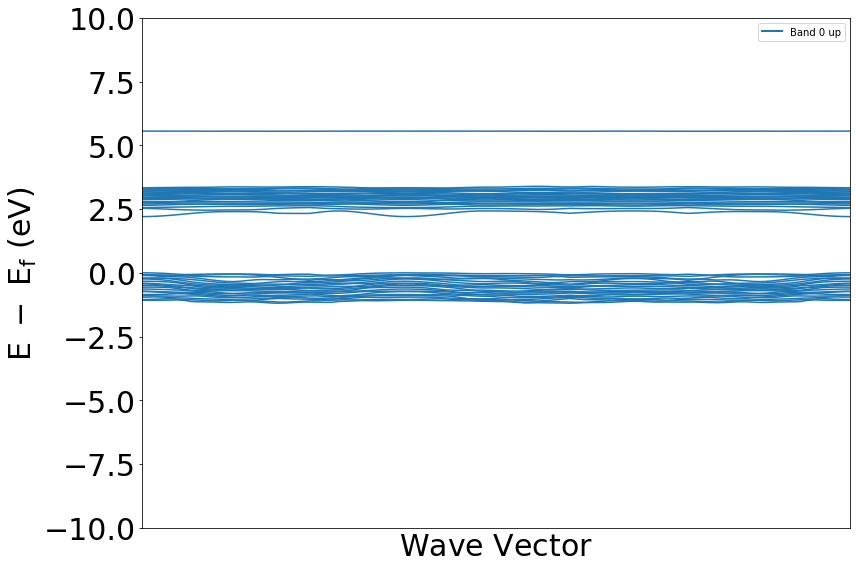

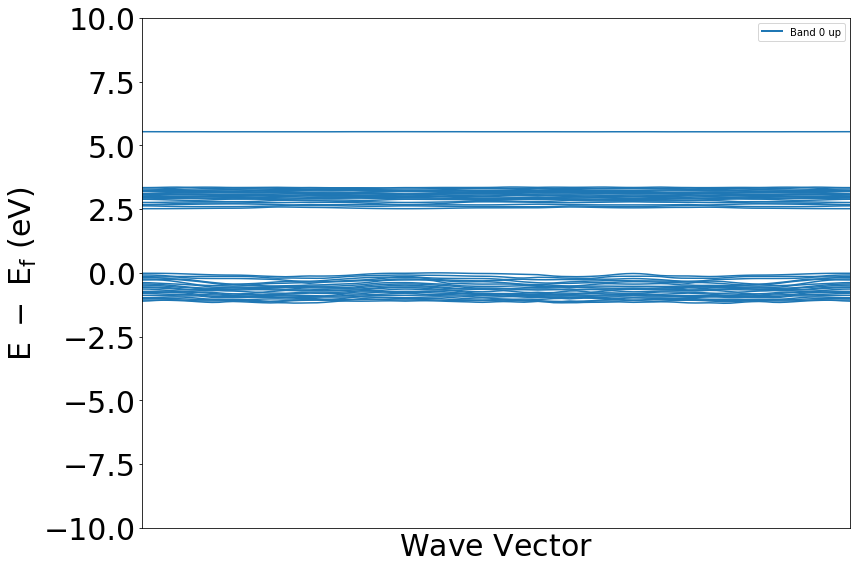

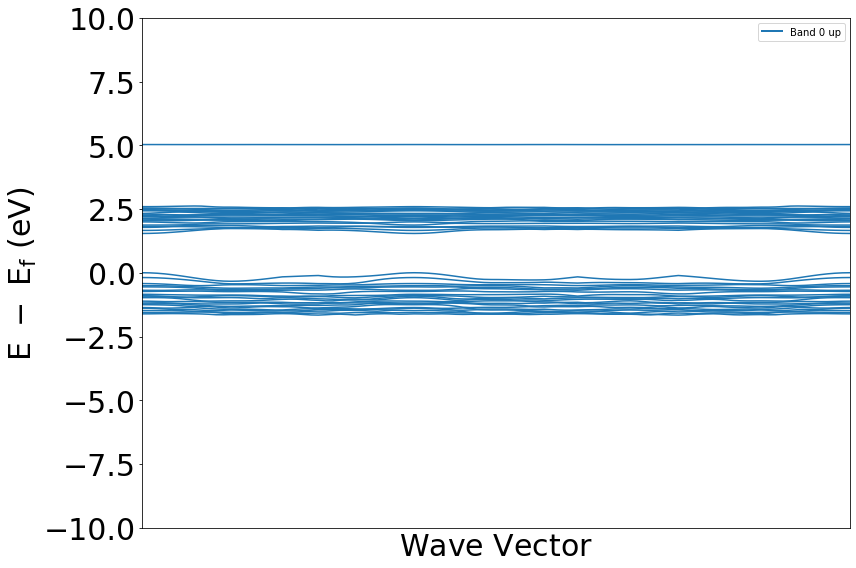

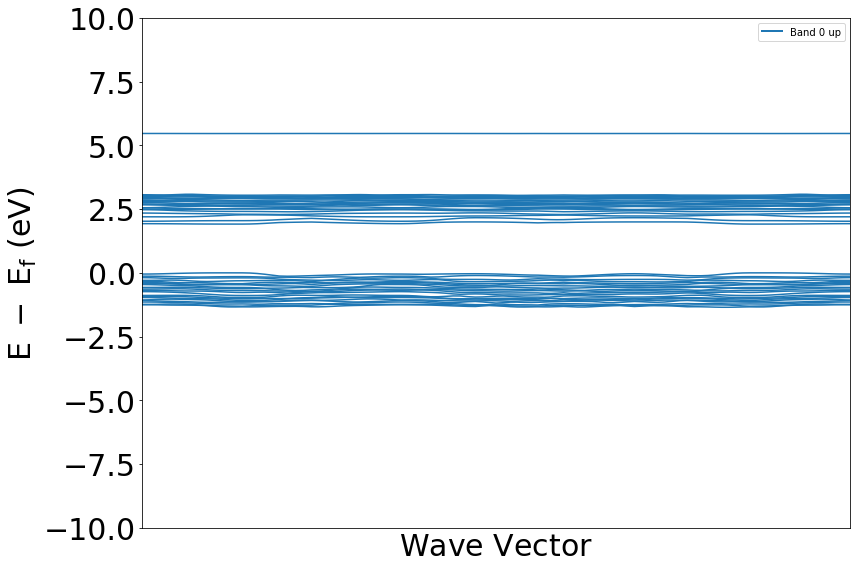

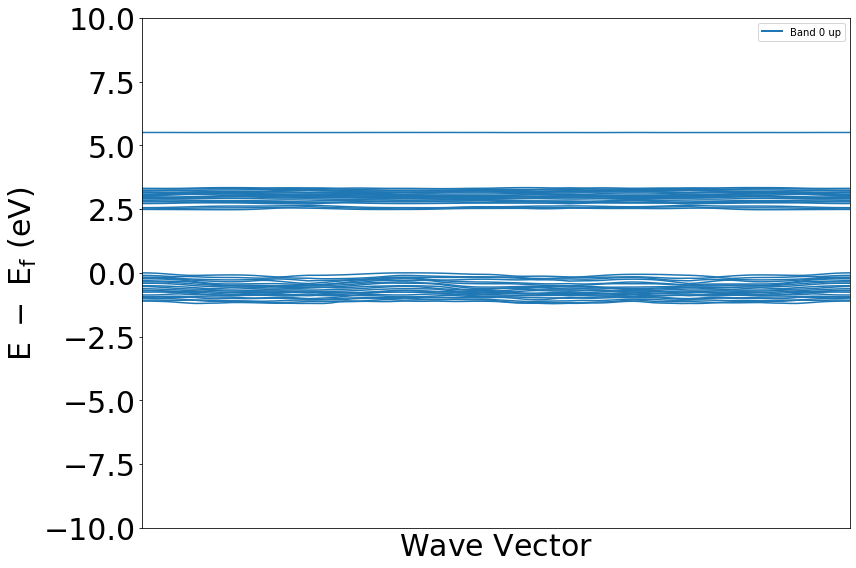

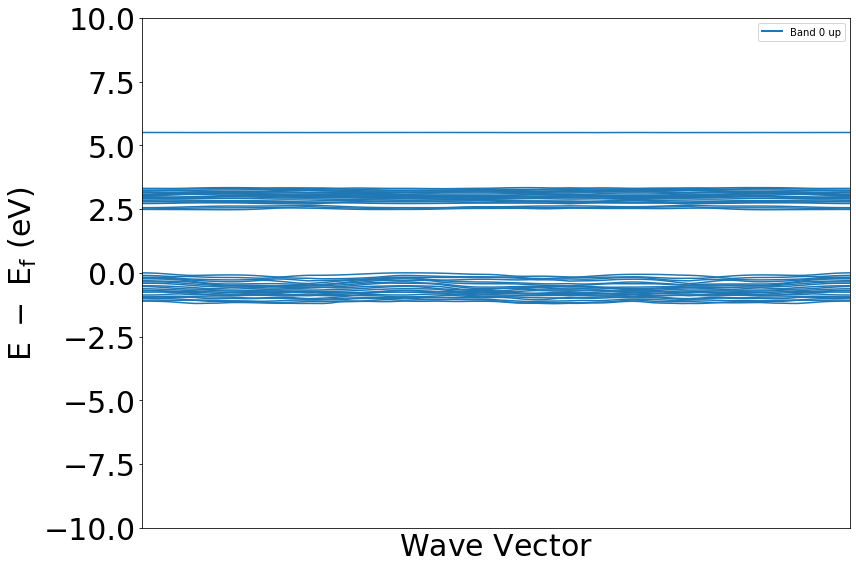

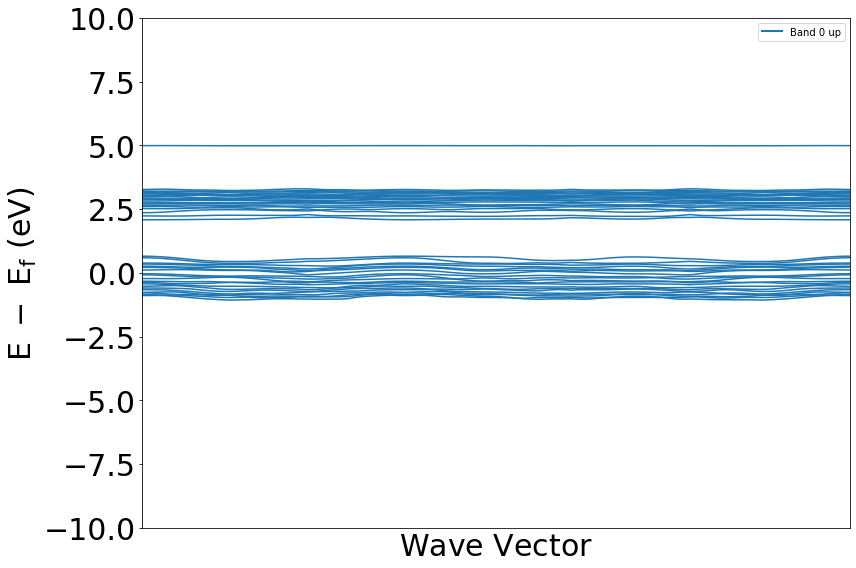

In [436]:
%matplotlib inline
for structure in selected_structures:
    output = Crystal_output('data/calculations/optgeom/LTS_%s_B3LYP_Ahl_b.out'%structure)
    bands = Crystal_bands('data/calculations/bands/LTS_%s_bands.BAND'%structure)
    bs = cry_bands2pmg(output,bands)
    bsplot = BSPlotter(bs)
    bsplot.get_plot(ylim=(-10, 10), zero_to_efermi=True)

## Density of States

### Write input

In [ ]:
with open('data/calculations/doss/doss_file.d3') as file:
    data = file.readlines()
for structure in selected_structures:
    input_dos = data
    structure_n = structure-1
    atomic_n = structures[structure_n].atomic_numbers
    #print(atomic_n)
    data[5] = '-18 '+' '.join(str(x) for x in np.where(np.array(atomic_n) == 3)[0]+1)+ '\n'
    data[6] = '-9 '+' '.join(str(x) for x in np.where(np.array(atomic_n) == 22)[0]+1)+ '\n'
    data[7] = '-27 '+' '.join(str(x) for x in np.where(np.array(atomic_n) == 16)[0]+1)+ '\n'
    with open('data/calculations/doss/LTS_%s_doss.d3'%structure, 'w') as file:
        for line in data:
            file.writelines(line)

## Dataframe distances

In [303]:
df = pd.DataFrame(list(zip(ti_s_distance_average,ti_s_distance_min,ti_s_distance_max,
                           li_s_distance_average,li_s_distance_min,li_s_distance_max,
                            energy, desc)),
                 columns=['Ti-S average','Ti-S min','Ti-S max','Li-S average','Li-S min','Li-S max','Energy'],
                 index=selected_structures)
df

,Ti-S average,Ti-S min,Ti-S max,Li-S average,Li-S min,Li-S max,Energy
2,2.513907,2.203215,3.121696,2.657878,2.476609,2.960605,-504325.966862
119,2.524380,2.211848,3.284352,2.659055,2.506490,3.031644,-504326.120067
127,2.486462,2.211321,2.800346,2.597115,2.346490,2.889657,-504323.357575
218,2.511078,2.212077,3.626212,2.653242,2.311574,3.484197,-504322.518462
348,2.522662,2.208594,3.425028,2.665644,2.482538,3.025510,-504326.227486
650,2.522639,2.208197,3.428830,2.665753,2.482435,3.032358,-504326.226982
721,2.495579,2.209846,2.875286,2.603160,2.322269,2.970346,-504322.161685
840,2.537512,2.208166,3.552181,2.666424,2.469215,3.158455,-504325.660024
868,2.483855,2.258656,2.901415,2.600277,2.455273,2.751357,-504326.175541
1363,2.486782,2.223719,2.897184,2.601252,2.500145,2.747445,-504326.489641
